In [1]:
import sys
import torch
import ot

import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../lib")
from distributions import sampleWrappedNormal
from utils_hyperbolic import *
from hsw import hyper_sliced_wasserstein
from hhsw import horo_hyper_sliced_wasserstein_lorentz, horo_hyper_sliced_wasserstein_poincare
from sw import sliced_wasserstein
from utility import *

device = "cuda" if torch.cuda.is_available() else "cpu"

## Lorentz Model

### low dimension

In [2]:
mu0 = torch.tensor([1,0,0,0], dtype=torch.float64, device=device)
Sigma0 = torch.eye(3, dtype=torch.float, device=device)

x0 = torch.from_numpy(np.array([1,0,0,0])).to(device)
v = torch.from_numpy(np.array([0,1,1,1])/np.sqrt(3)).to(device)

n_try = 10
n = 1000
nn = 200

t = torch.linspace(-10, 10, 201, dtype=torch.float64).to(device)
mus = torch.cosh(t)[:,None] * x0 + torch.sinh(t)[:,None] * v/torch.linalg.norm(v)

In [3]:
L_w = np.zeros((len(mus), n_try))
L_swp = np.zeros((len(mus), n_try))
L_hsw = np.zeros((len(mus), n_try))
L_hhsw = np.zeros((len(mus), n_try))
L_sw = np.zeros((len(mus), n_try))
L_sfw = np.zeros((len(mus), n_try))
L_sfwp = np.zeros((len(mus), n_try))
L_iprsfw_geo = np.zeros((len(mus), n_try))
L_iprsfw_horo = np.zeros((len(mus), n_try))
i = 0


for i, mu in enumerate(mus):
    for k in range(n_try):
        x0 = sampleWrappedNormal(mu, Sigma0, n)
        x1 = sampleWrappedNormal(mu0, Sigma0, n)

        distance = hyper_sliced_wasserstein(x0, x1, 100, device, p=2)
        L_hsw[i,k] = distance.item()

        distance = horo_hyper_sliced_wasserstein_lorentz(x0, x1, 100, device, p=2)
        L_hhsw[i,k] = distance.item()

        distance = sliced_wasserstein(x0, x1, 100, device, p=2)
        L_sw[i,k] = distance.item()

        distance = sliced_wasserstein(lorentz_to_poincare(x0), lorentz_to_poincare(x1), 100, device, p=2)
        L_swp[i,k] = distance.item()

        distance = SFW(x0,x1,hyperbolic_model="Lorentz",spf_curve="Mm_l")
        L_sfw[i,k] = distance.item()**2

        distance = SFW(x0,x1,hyperbolic_model="Lorentz",spf_curve="Mm_p")
        L_sfwp[i,k] = distance.item()**2

        distance = IPRSFW(x0,x1,hyperbolic_model="Lorentz",spf_curve="Mm_l",projection_kind="geodesic", q=2, nslice=50, p=2, eps=1e-5, device=device)
        L_iprsfw_geo[i,k] = distance.item()**2

        distance = IPRSFW(x0,x1,hyperbolic_model="Lorentz",spf_curve="Mm_l",projection_kind="horospherical", q=2, nslice=50, p=2, eps=1e-5, device=device)
        L_iprsfw_horo[i,k] = distance.item()**2


        x0 = sampleWrappedNormal(mu, Sigma0, nn)
        x1 = sampleWrappedNormal(mu0, Sigma0, nn)

        a = torch.ones((nn,), device=device)/nn
        b = torch.ones((nn,), device=device)/nn
        M = torch.arccosh(torch.clamp(-minkowski_ip2(x0, x1), min=1+1e-5))**2
        distance = ot.emd2(a, b, M)
        L_w[i,k] = distance.item()

    
    i += 1
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201


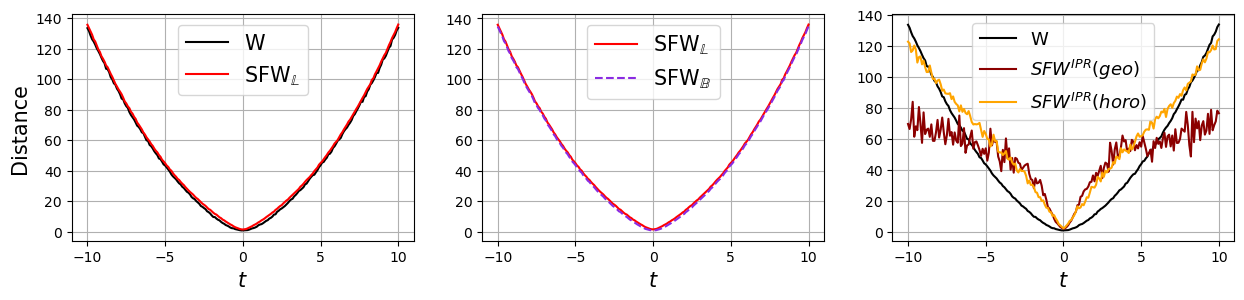

In [25]:
L_hsw_m = np.mean(L_hsw,1)
L_w_m = np.mean(L_w,1)
L_hhsw_m = np.mean(L_hhsw,1)
L_sw_m = np.mean(L_sw,1)
L_swp_m = np.mean(L_swp,1)
L_sfw_m = np.mean(L_sfw,1)
L_sfwp_m = np.mean(L_sfwp,1)
L_iprsfw_geo_m = np.mean(L_iprsfw_geo,1)
L_iprsfw_horo_m = np.mean(L_iprsfw_horo,1)


plt.figure(dpi=100,figsize=(15,3))

plt.subplot(1,3,1)
plt.plot(t.detach().cpu(),L_w_m,c="k",linestyle="-",label="W")
plt.plot(t.detach().cpu(),L_sfw_m,c="r",label=r"SFW$_\mathbb{L}$")
plt.legend(fontsize=15, loc="upper center")
plt.xlabel(r"$t$", fontsize=15)
plt.ylabel(r"Distance", fontsize=15)
plt.grid(True)


plt.subplot(1,3,2)
plt.plot(t.detach().cpu(),L_sfw_m,c="r",label=r"SFW$_\mathbb{L}$")
plt.plot(t.detach().cpu(),L_sfwp_m,c="blueviolet",linestyle="dashed",label=r"SFW$_\mathbb{B}$")
plt.legend(fontsize=15, loc="upper center")
plt.xlabel(r"$t$", fontsize=15)
plt.grid(True)


plt.subplot(1,3,3)
plt.plot(t.detach().cpu(),L_w_m,c="k",linestyle="-",label="W")
plt.plot(t.detach().cpu(),L_iprsfw_geo_m,c="darkred",label=r"$SFW^{IPR}(geo)$")
plt.plot(t.detach().cpu(),L_iprsfw_horo_m,c="orange",label=r"$SFW^{IPR}(horo)$")
plt.legend(fontsize=13, loc="upper center")
plt.xlabel(r"$t$", fontsize=15)


plt.savefig("./evol_supp.pdf", format="pdf", bbox_inches="tight")
plt.grid(True)

### high dimension

In [26]:
mu_ = np.zeros(20)
mu_[0] = 1

mu0 = torch.tensor(mu_, dtype=torch.float64, device=device)
Sigma0 = torch.eye(19, dtype=torch.float, device=device)


x0 = torch.from_numpy(mu_).to(device)
v = torch.from_numpy((1-mu_)/np.sqrt(19)).to(device)


n_try = 10
n = 1000
nn = 200

t = torch.linspace(-10, 10, 201, dtype=torch.float64).to(device)
mus = torch.cosh(t)[:,None] * x0 + torch.sinh(t)[:,None] * v/torch.linalg.norm(v)

In [27]:
L_w = np.zeros((len(mus), n_try))
L_hsw = np.zeros((len(mus), n_try))
L_hhsw = np.zeros((len(mus), n_try))
L_sw = np.zeros((len(mus), n_try))
L_sfw = np.zeros((len(mus), n_try))
L_sfwp = np.zeros((len(mus), n_try))
L_iprsfw_geo = np.zeros((len(mus), n_try))
L_iprsfw_horo = np.zeros((len(mus), n_try))
i = 0


for i, mu in enumerate(mus):
    for k in range(n_try):
        x0 = sampleWrappedNormal(mu, Sigma0, n)
        x1 = sampleWrappedNormal(mu0, Sigma0, n)

        distance = hyper_sliced_wasserstein(x0, x1, 100, device, p=2)
        L_hsw[i,k] = distance.item()

        distance = horo_hyper_sliced_wasserstein_lorentz(x0, x1, 100, device, p=2)
        L_hhsw[i,k] = distance.item()

        distance = sliced_wasserstein(x0, x1, 100, device, p=2)
        L_sw[i,k] = distance.item()

        distance = SFW(x0,x1,hyperbolic_model="Lorentz",spf_curve="Mm_l")
        L_sfw[i,k] = distance.item()**2

        distance = SFW(x0,x1,hyperbolic_model="Lorentz",spf_curve="Mm_p")
        L_sfwp[i,k] = distance.item()**2

        distance = IPRSFW(x0,x1,hyperbolic_model="Lorentz",spf_curve="Mm_l",projection_kind="geodesic", q=2, nslice=50, p=2, eps=1e-5, device=device)
        L_iprsfw_geo[i,k] = distance.item()**2

        distance = IPRSFW(x0,x1,hyperbolic_model="Lorentz",spf_curve="Mm_l",projection_kind="horospherical", q=2, nslice=50, p=2, eps=1e-5, device=device)
        L_iprsfw_horo[i,k] = distance.item()**2


        x0 = sampleWrappedNormal(mu, Sigma0, nn)
        x1 = sampleWrappedNormal(mu0, Sigma0, nn)

        a = torch.ones((nn,), device=device)/nn
        b = torch.ones((nn,), device=device)/nn
        M = torch.arccosh(torch.clamp(-minkowski_ip2(x0, x1), min=1+1e-5))**2
        distance = ot.emd2(a, b, M)
        L_w[i,k] = distance.item()

    
    i += 1
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201


<Figure size 1200x800 with 0 Axes>

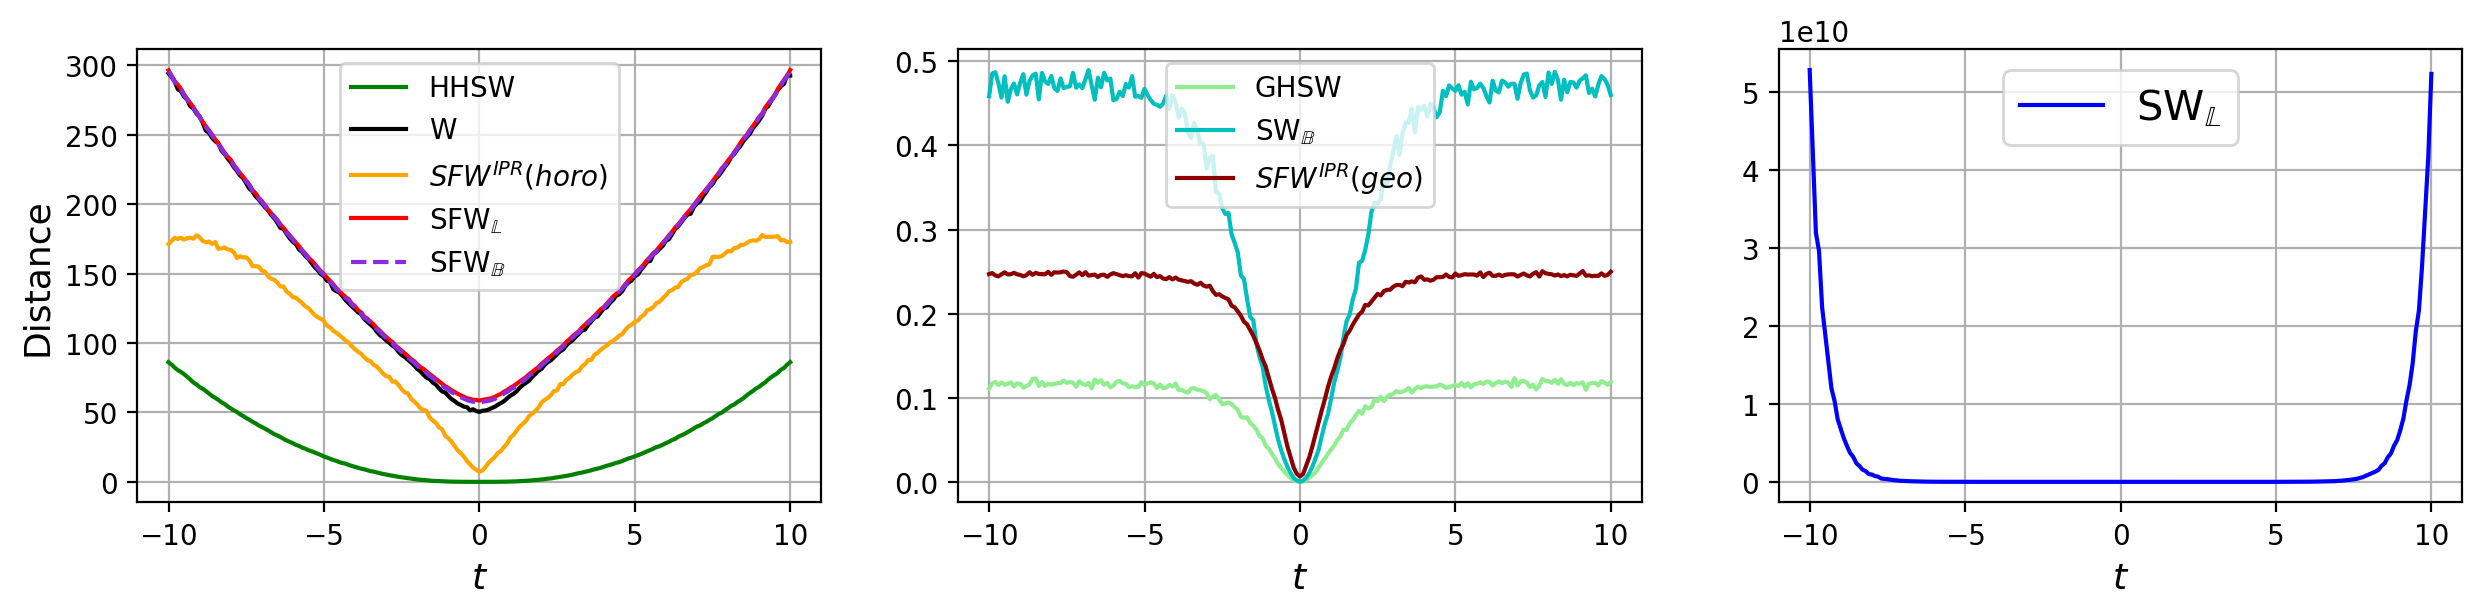

In [38]:
plt.figure(dpi=200)
L_hsw_m = np.mean(L_hsw,1)
L_w_m = np.mean(L_w,1)
L_hhsw_m = np.mean(L_hhsw,1)
L_sw_m = np.mean(L_sw,1)
L_swp_m = np.mean(L_swp,1)
L_sfw_m = np.mean(L_sfw,1)
L_sfwp_m = np.mean(L_sfwp,1)
L_iprsfw_geo_m = np.mean(L_iprsfw_geo,1)
L_iprsfw_horo_m = np.mean(L_iprsfw_horo,1)


plt.figure(dpi=200,figsize=(15,3))

plt.subplot(1,3,1)
plt.plot(t.detach().cpu(),L_hhsw_m,c="g",label="HHSW")
plt.plot(t.detach().cpu(),L_w_m,c="k",label="W")
plt.plot(t.detach().cpu(),L_iprsfw_horo_m,c="orange",label=r"$SFW^{IPR}(horo)$")
plt.plot(t.detach().cpu(),L_sfw_m,c="r",label=r"SFW$_\mathbb{L}$")
plt.plot(t.detach().cpu(),L_sfwp_m,c="blueviolet",linestyle="dashed",label=r"SFW$_\mathbb{B}$")
plt.legend(fontsize=10, loc="upper center")
plt.xlabel(r"$t$", fontsize=13)
plt.ylabel(r"Distance", fontsize=13)

plt.grid(True)

plt.subplot(1,3,2)

plt.plot(t.detach().cpu(),L_hsw_m,c="lightgreen",label="GHSW")
plt.plot(t.detach().cpu(),L_swp_m,c="c",label=r"SW$_\mathbb{B}$")
plt.plot(t.detach().cpu(),L_iprsfw_geo_m,c="darkred",label=r"$SFW^{IPR}(geo)$")
plt.legend(fontsize=10)
plt.xlabel(r"$t$", fontsize=13)
# plt.ylabel(r"Distance", fontsize=13)
plt.grid(True)


plt.subplot(1,3,3)
plt.plot(t.detach().cpu(),L_sw_m,c="b",label=r"SW$_\mathbb{L}$")
plt.legend(fontsize=15, loc="upper center")
plt.xlabel(r"$t$", fontsize=13)
# plt.ylabel(r"Distance", fontsize=13)

plt.grid(True)

plt.savefig("./evol_supp2.pdf", format="pdf", bbox_inches="tight")

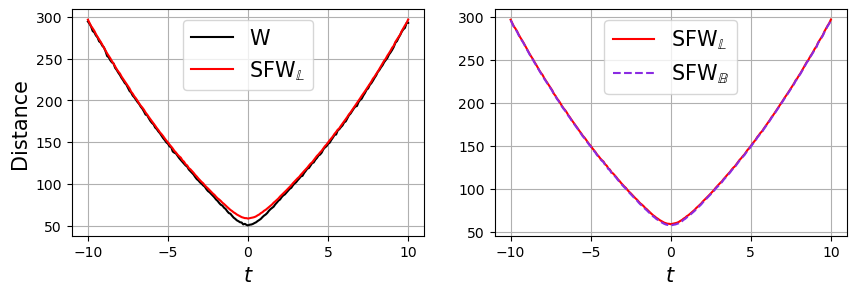

In [37]:
L_hsw_m = np.mean(L_hsw,1)
L_w_m = np.mean(L_w,1)
L_hhsw_m = np.mean(L_hhsw,1)
L_sw_m = np.mean(L_sw,1)
L_swp_m = np.mean(L_swp,1)
L_sfw_m = np.mean(L_sfw,1)
L_sfwp_m = np.mean(L_sfwp,1)
L_iprsfw_geo_m = np.mean(L_iprsfw_geo,1)
L_iprsfw_horo_m = np.mean(L_iprsfw_horo,1)


plt.figure(dpi=100,figsize=(10,3))

plt.subplot(1,2,1)
plt.plot(t.detach().cpu(),L_w_m,c="k",linestyle="-",label="W")
plt.plot(t.detach().cpu(),L_sfw_m,c="r",label=r"SFW$_\mathbb{L}$")
plt.legend(fontsize=15, loc="upper center")
plt.xlabel(r"$t$", fontsize=15)
plt.ylabel(r"Distance", fontsize=15)
plt.grid(True)


plt.subplot(1,2,2)
plt.plot(t.detach().cpu(),L_sfw_m,c="r",label=r"SFW$_\mathbb{L}$")
plt.plot(t.detach().cpu(),L_sfwp_m,c="blueviolet",linestyle="dashed",label=r"SFW$_\mathbb{B}$")
plt.legend(fontsize=15, loc="upper center")
plt.xlabel(r"$t$", fontsize=15)
plt.grid(True)



# plt.savefig("../results/evolution_supp2.pdf", format="pdf", bbox_inches="tight")